<a href="https://colab.research.google.com/github/fedhere/MLTSA22_JHicks/blob/main/HW4/JH_HW4_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=red>FBB: very good! </font>

In [ ]:
import pandas as pd
import pylab as pl
%pylab inline
import numpy as np
from scipy.stats import chisquare

Populating the interactive namespace from numpy and matplotlib


## Data analysis 0

In [ ]:
!pip install fbprophet

In [ ]:
import fbprophet
from fbprophet import Prophet
from fbprophet import diagnostics

## Data acquisition 1

In [ ]:
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
  begin = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-'
  end = '14.csv'
  a.append(begin + mon + end)    

In [ ]:
uberrides = pd.read_csv(a[0])
for i in a[1:]:
  uberrides = pd.concat([uberrides, pd.read_csv(i)])

In [ ]:
uberrides.shape

(4534327, 4)

In [ ]:
uberrides.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


## Data preparation


In [ ]:
uberrides["time"] = pd.to_datetime(uberrides['Date/Time'])

In [ ]:
uberrides.head()

,Date/Time,Lat,Lon,Base,time
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,2014-04-01 00:11:00
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,2014-04-01 00:17:00
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,2014-04-01 00:21:00
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,2014-04-01 00:28:00
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,2014-04-01 00:33:00


In [ ]:
uberrides.iloc[0]["time"].date

<function Timestamp.date>

In [ ]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date)["time"].count().reset_index(name = 'ds')

In [ ]:
uberbyday = uberbyday.rename(columns = {'time': 'ds', 'ds': 'y'})

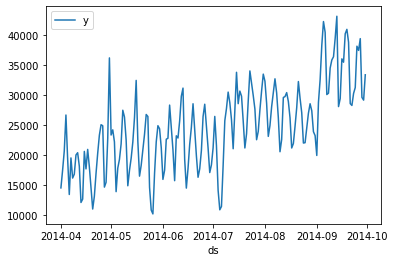

In [ ]:
uberbyday.plot(x = "ds", y = "y");

Fig. 1. The plot of the number of uberrides by day. On the x-axis - change over time, timepoints are in months; on the y-axis - the total number of rides. 

In [ ]:
uberbyday.head()

,ds,y
0,2014-04-01,14546
1,2014-04-02,17474
2,2014-04-03,20701
3,2014-04-04,26714
4,2014-04-05,19521


Data standartization

In [ ]:
uberbyday['y'] = (uberbyday['y'].values - uberbyday['y'].values.mean())/uberbyday['y'].values.std()

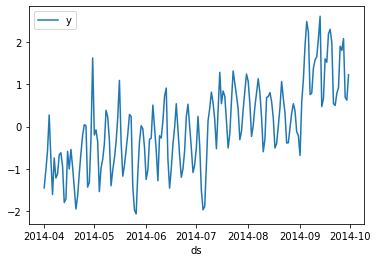

In [ ]:
uberbyday.plot(x = "ds", y = "y");

Fig. 2. The plot of the z-score standardized number of uberrides by day. On the x-axis - change over time, timepoints are in months; on the y-axis - the z-score standardized total number of rides.

<font color=red>FBB: good - thanks for describing the axes, but what do you see? there is a slow growth trend, a short term seasonality, some points that are unexoected based on these trends and a break at 2014-09 wich a change of behavior - these considerations will support the rest of the analysis and the creation of complex models</font>

# DATA ANALYSIS
## Model 1. Trens and seasonality

In [ ]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = pd.DataFrame()
future['ds'] = pd.date_range(start = '2014-10-01', end = '2014-10-30')
future = pd.concat([uberbyday[['ds']], future])

In [ ]:
forecast = simplem.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,0.677324,0.041705,1.344891
209,2014-10-27,0.956448,0.245613,1.581760
210,2014-10-28,1.534004,0.789196,2.173640
211,2014-10-29,1.891270,1.200423,2.486532
212,2014-10-30,2.210467,1.524538,2.887084


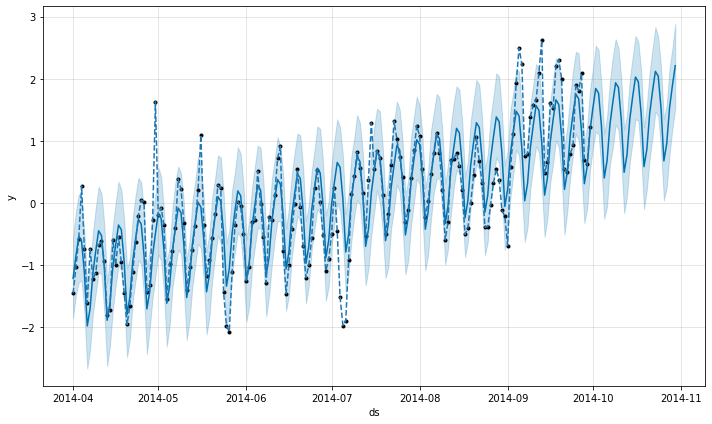

In [ ]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday['ds'], uberbyday['y'], '--');

Fig. 3.  The plot depicting the fit of our 'simplem' model. The dashed line connects the standardized number of rides (black dots) over days (daily trends). The solid blue line is the prediction of our 'simplem' model over the datapoints that we already have for the period from april to september (including), and additionally over november. It also includes the uncertainty regions of the forecast in light blue.
Judging by the plot, our prediction model does a good job fitting to our data. 

<font color=red>FBB: good description. does it do a good job tho? I would say that it does a good job for the general behavior but fails entirely to predict anomalies and the change around 2014-09

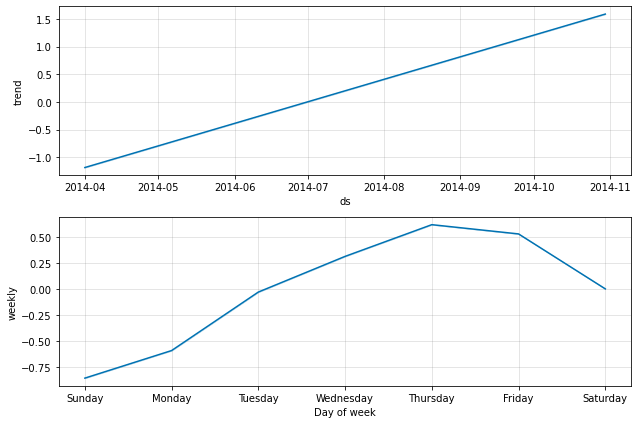

In [ ]:
fig2 = simplem.plot_components(forecast)

Fig. 4. The comonents 'trend' and 'weekly seasonality' of the forecast in our 'simplem' model. Trend component depict overall gradual rising in number of rides with time, whereas seasonality component implies the greatest demand for uberrides on Thursdays and Fridays and the lowes - on Sundays.

<font color=red>FBB:  very good</font>

Model validation

In [ ]:
cvresult_simplem = diagnostics.cross_validation(simplem, '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def rchi2(y, ytrue): #y_true - true y, y - predicted y
  dof = 182
  chi2 = sum(((ytrue - y)**2)/ytrue)
  rchi2 = chi2/dof
  return rchi2
rchi2(cvresult_simplem['yhat'], cvresult_simplem['y'])

0.41047830335233704

<font color=red>FBB:  why hardcoding 182? you knwo that that is the number of observations - 1 so len(ytrue)-1. why not calculate it inside of the function?</font>

The more these values correcsponding to the number of uberrides diverge from each other, the higher the chi square score. In our case, I would hypothesize that the higher the chi square, the less accurate the model is, meaning it predicts the values with bigger discrepancies compared to the real values.


## Data acquisition 2

In [ ]:
!pip install wwo_hist

In [ ]:
from wwo_hist import retrieve_hist_data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/MLTSA22/HW4/

/content/gdrive/MyDrive/MLTSA22/HW4


In [ ]:
frequency = 24
start_date = pd.to_datetime('2014-04-01')
end_date = pd.to_datetime('2014-10-30')
api_key = pd.read_csv('my_api.csv', header=None, index_col=0).loc['wwo'].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:02.190635
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:03.685012
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:05.299636
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:07.044262
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:09.123919
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:11.058084
Currently retrieving data for New+york,ny: from 2014-10-01 to 2014-10-30
Time elapsed (hh:mm:ss.ms) 0:00:12.534583


export New+york,ny completed!




In [ ]:
weather = pd.read_csv("New+york,ny.csv")
weather['ds'] = pd.to_datetime(weather['date_time'])
weather['tempC'] =  (weather['tempC'].values -  weather['tempC'].values.mean())/ weather['tempC'].values.std()
weather['precipMM'] = (weather['precipMM'].values -  weather['precipMM'].values.mean())/ weather['precipMM'].values.std()
weather = weather[['ds', 'tempC', 'precipMM']]

In [ ]:
uberbyday['ds'] = pd.to_datetime(weather['ds'])
uberweather = uberbyday.merge(right = weather, on = 'ds') 
#I extracted weather for november as well, but after merging it includes values only up to september
#So later on, in model prediction, we predict solely for the data that we already have.

In [ ]:
uberweather

,ds,y,tempC,precipMM
0,2014-04-01,-1.453505,-1.792779,-0.576479
1,2014-04-02,-1.037558,-1.610940,-0.456952
2,2014-04-03,-0.579136,-1.429101,-0.576479
3,2014-04-04,0.275062,-2.701974,0.439500
4,2014-04-05,-0.746764,-2.156457,-0.253756
...,...,...,...,...
178,2014-09-26,1.807871,0.934806,-0.576479
179,2014-09-27,2.086874,1.480323,-0.576479
180,2014-09-28,0.692997,0.752967,-0.576479
181,2014-09-29,0.628361,0.571128,-0.564526


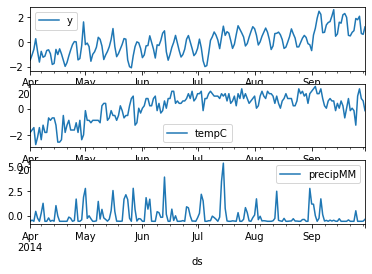

In [ ]:
fig, ax = pl.subplots(3)
uberweather.plot(x= 'ds', y="y", ax=ax[0])
uberweather.plot(x= 'ds', y="tempC", ax=ax[1])
uberweather.plot(x= 'ds', y="precipMM", ax=ax[2])

Fig. 5. The first plot shows the standardized total number of uberrides over time. The second plot depicts the standardized temperature in celcius over time. The last plot - the standardized precipitation value (any liquid or frozen water that forms in the atmosphere and falls back to the Earth) over time. 

<font color=red>FBB: good</font>

## Model 2. Trends, seasonality, and exogeneous weather variables.

In [ ]:
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')

In [ ]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


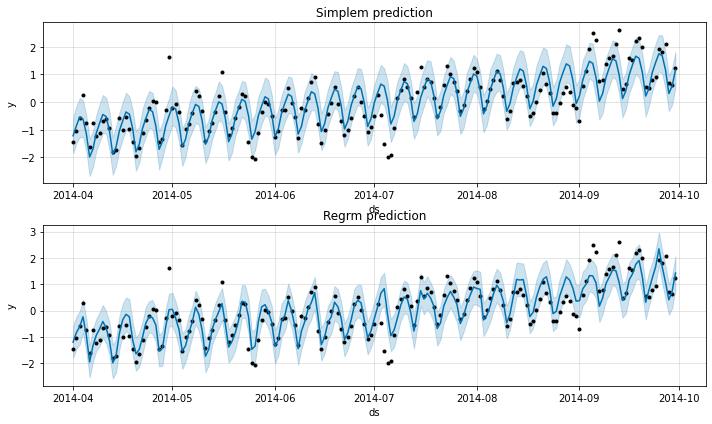

In [ ]:
regrmcast = regrm.predict(uberweather)
#plotting
fig, (ax1, ax2) = pl.subplots(2,1, figsize = (10,6))
simplem.plot(forecast[:-30], ax=ax1)
ax1.set_title('Simplem prediction')
regrm.plot(regrmcast, ax=ax2)
ax2.set_title('Regrm prediction');

Fig. 6. The upper plot shows the prediction of the uberrides over time by the 'simplem' model by the extrapolation from trend and seasonality (solid blue line). The bottom plot - the prediction of uberrides over time by the 'regrm' model over time with the addition of weather exogeneous variables (solid blue line). Black dots correspond to the true standardized number of uberrides over time. Judging by the plot alone, the 'regrm' model seems to fit closer to the real data points (we can see the 'sharpening' of edges). 

<font color=red>FBB: very good</font>

In [ ]:
cvresult_regrm = diagnostics.cross_validation(model = regrm, horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print('Simplem rchi2:', rchi2(cvresult_simplem['yhat'],cvresult_simplem['y']))
print('Regrm rchi2:', rchi2(cvresult_regrm['yhat'], cvresult_regrm['y']))

0.41047830335233704
0.43169256248448107


The chi square for the 2nd model slightly increased meaning there is slightly more divergence between the real and predicted number of uberrides. 

<font color=red>FBB: my guess is that this is due entirely to the prediction around 2014/09</font>

## Model 3. Trends, seasonality, weather exogeneous variables, and holidays

In [ ]:
regholm = Prophet()
regholm.add_country_holidays(country_name="US")

In [ ]:
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Regholm prediction')

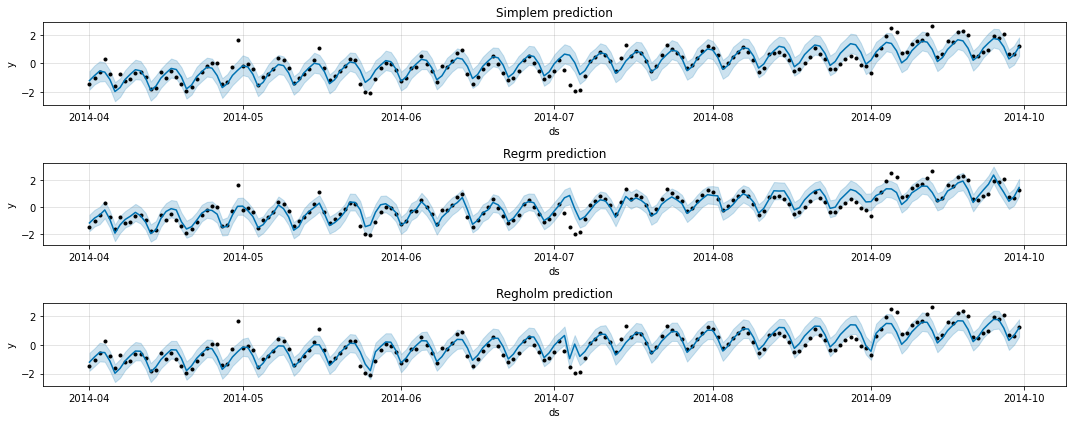

In [ ]:
regholmcast = regholm.predict(uberweather)
fig, (ax1, ax2, ax3) = pl.subplots(3,1, figsize = (10,6))
simplem.plot(forecast[:-30], ax = ax1)
ax1.set_title('Simplem prediction')
regrm.plot(regrmcast, ax = ax2)
ax2.set_title('Regrm prediction')
regholm.plot(regholmcast, ax = ax3)
ax3.set_title('Regholm prediction')

Fig. 7. The bottom plot - the prediction of uberrides over time by the 'regholm' model over time with the addition of holidays (solid blue line). Black dots correspond to the true standardized number of uberrides over time.

<font color=red>FBB: these small y axis plot make it really hard to tell what is goiung on on your prediction cause the endogenous variable range is so compressed</font>

In [ ]:
cvresult_regholm = diagnostics.cross_validation(model = regholm, horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print('Simplem rchi2:', rchi2(cvresult_simplem['yhat'],cvresult_simplem['y']))
print('Regrm rchi2:', rchi2(cvresult_regrm['yhat'], cvresult_regrm['y']))
print('Regholm rchi2:', rchi2(cvresult_regholm['yhat'],cvresult_regholm['y']))

Simplem rchi2: 0.41047830335233704
Regrm rchi2: 0.43169256248448107
Regholm rchi2: 0.38048527496942536


The chi square for the 3rd model 'regholm' slightly decreased compared to other models suggesting that it fits better and there is slightly less divergence between the real and predicted number of uberrides.

## Model 4. Trends, seasonality, weather variables, holidays, and mcmc implementation.

In [ ]:
regmcmc = Prophet(mcmc_samples=5000)
regmcmc.add_regressor(name = 'tempC')
regmcmc.add_regressor(name = 'precipMM')
regmcmc.add_country_holidays(country_name = 'US')

In [ ]:
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


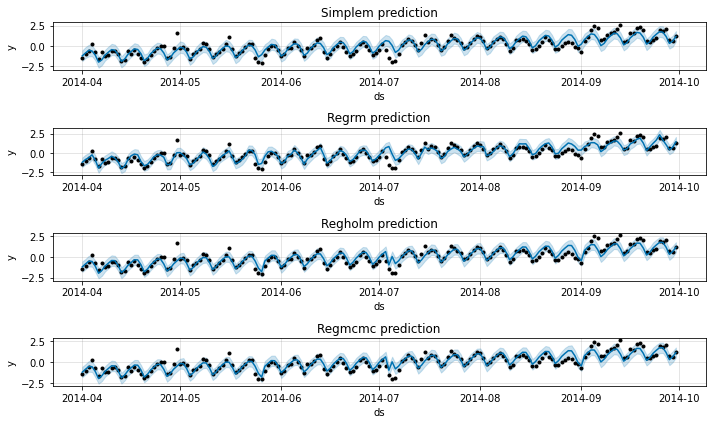

In [ ]:
regmcmccast = regmcmc.predict(uberweather)
fig, (ax1, ax2, ax3, ax4) = pl.subplots(4,1, figsize = (10,6))
simplem.plot(forecast[:-30], ax = ax1)
ax1.set_title('Simplem prediction')
regrm.plot(regrmcast, ax = ax2)
ax2.set_title('Regrm prediction')
regholm.plot(regholmcast, ax = ax3)
ax3.set_title('Regholm prediction')
regholm.plot(regholmcast, ax = ax4)
ax4.set_title('Regmcmc prediction');

Fig. 8. The bottom plot - the prediction of uberrides over time by the 'regmcmc' model over time with the mcmc optimization (solid blue line). Black dots correspond to the true standardized number of uberrides over time.

In [ ]:
cvresult_regmcmc = diagnostics.cross_validation(model = regmcmc, horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print('Simplem rchi2:', rchi2(cvresult_simplem['yhat'],cvresult_simplem['y']))
print('Regrm rchi2:', rchi2(cvresult_regrm['yhat'], cvresult_regrm['y']))
print('Regholm rchi2:', rchi2(cvresult_regholm['yhat'],cvresult_regholm['y']))
print('Regmcmc rchi2:', rchi2(cvresult_regmcmc['yhat'],cvresult_simplem['y']))

Simplem rchi2: 0.41047830335233704
Regrm rchi2: 0.43169256248448107
Regholm rchi2: 0.38048527496942536
Regmcmc rchi2: 0.4329461148049993


The chi square for the 3rd model 'regholm' is slightly decreased compared to other models suggesting that it fits better and there is slightly less divergence between the real and predicted number of uberrides compared to other models.

<font color=red>FBB: good!</font>